# Chess in Python

Here I'll be working towards creating a chess engine using deep learning.

## Simulating Chess Matches

I want to start off by creating a chess match simulator. This will be what the engine will interact with in order to train. First thing we do here is import the necessary packages and demonstrate a bit of how they work.

In [1]:
import chess
import chess.pgn

In [18]:
game = chess.pgn.Game()
board = game.board()

In [28]:
game.headers

OrderedDict([('Event', '?'),
             ('Site', '?'),
             ('Date', '????.??.??'),
             ('Round', '?'),
             ('White', '?'),
             ('Black', '?'),
             ('Result', '*')])

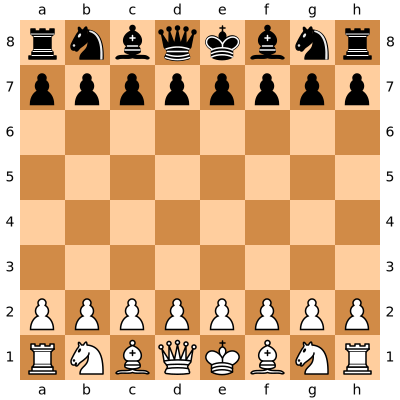

In [19]:
board

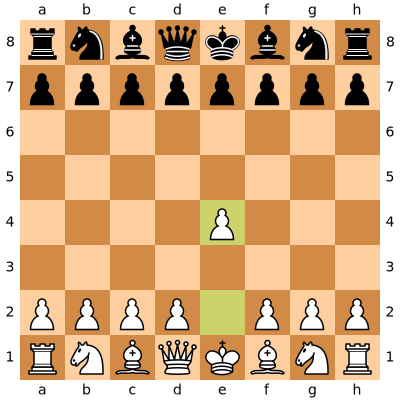

In [22]:
board.push(chess.Move.from_uci("e2e4"))
board

In [25]:
board.reset_board()

Pretty straightforward. Next we create a program that simulates random chess games where the moves are selected uniformly at random.

In [45]:
def simulate_game():
    
    def get_current_time():
        from datetime import datetime
        return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")
    
    def initialise_game():
        game = chess.pgn.Game()
        board = game.board()
        game.headers['Date'] = get_current_time()
        game.headers['Black'] = 'Random Agent'
        game.headers['White'] = 'Random Agent'
        return game, board
    
    def get_next_move():
        from random import sample
        return sample(list(board.legal_moves), 1)[0]
        
    game, board = initialise_game()
    next_move = get_next_move()
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move()
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['result'] = board.result()
    
    return game, board

[Event "?"]
[Site "?"]
[Date "2017/11/13 17:36:56.316058"]
[Round "?"]
[White "Random Agent"]
[Black "Random Agent"]
[Result "*"]
[result "1-0"]

1. h4 h5 2. c4 Nf6 3. Rh3 Nc6 4. g4 Rg8 5. Bg2 d5 6. d4 Qd7 7. Rh2 b5 8. Nc3 Qxg4 9. Qb3 Qg6 10. Bh1 Qh7 11. Qb4 Qg6 12. Qc5 Qg2 13. Kd2 Rh8 14. Qb4 Qg6 15. Be4 e5 16. a3 Qh6+ 17. Kc2 Bb7 18. Kd3 Rc8 19. Na2 Qg6 20. Qc3 Rd8 21. Rb1 Nd7 22. Nh3 Bc5 23. dxc5 Ke7 24. cxb5 Qg4 25. Bf3 f6 26. Ke3 Qxf3+ 27. Kxf3 e4+ 28. Ke3 a5 29. Qd3 Rh6 30. Kf4 Ncb8 31. e3 Bc6 32. Qc2 Nxc5 33. Rh1 Kd6 34. b3 f5 35. b4 Kd7 36. Re1 Rg8 37. Kg3 Re8 38. Bb2 Rf8 39. Ng1 Rg6+ 40. Kf4 Rg4+ 41. Ke5 Nba6 42. Qa4 d4 43. Re2 Nb3 44. bxc6+ Ke7 45. Rf1 Rd8 46. b5 Nbc5 47. f3 Nb4 48. Rc2 Rg8 49. Bxd4 Ra8 50. Nc1 Ncd3+ 51. Kxf5 Rc8 52. Rg2 Rxh4 53. Rc2 Rf4+ 54. exf4 Na2 55. Nxa2 Rg8 56. Qc4 exf3 57. Qb4+ Kf7 58. Bc5 Nxb4 59. Rd1 Rd8 60. Rd6 Rd7 61. Rh6 Kg8 62. Bxb4 Rd3 63. Re2 h4 64. Nh3 fxe2 65. Be1 Rb3 66. Bc3 e1=N 67. Be5 Rd3 68. Nb4 Rc3 69. Kg5 Rg3+ 70. Kf5 g6+ 71. Ke6 axb4

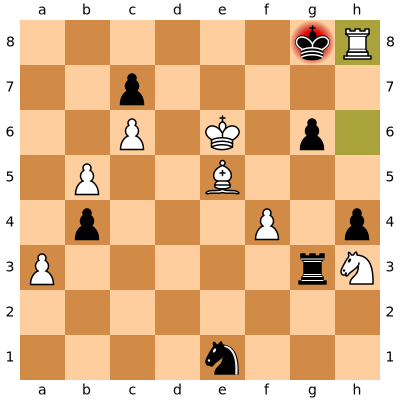

In [118]:
game, board = simulate_game()
print(game)
board

## Featurising Chess

Now that we can successfully simulate a random chess game, the next job is to turn the board position into a set of features that can be fed into a machine learning algorithm. In this part, I will take inspiration from the AlphaGo Zero model.

In [58]:
import numpy as np

We want to one-hot encode the positions of each piece on the board. As the package is written, board positions are stored using 64 bit integers. In order to repackage the board positions as a numpy array, we need to write a function to convert them.

In [104]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = bin(squares)[2:]
    # add starting zeroes if missing
    squares = '0' * (64 - len(squares)) + squares
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8,8)
    # flip along y axis (for some reason)
    squares = squares[:,::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

Now we can use `int_to_mask` to express where each piece on the board is as a numpy array.

In [107]:
int_to_mask(board.pieces_mask(color=chess.BLACK, piece_type=chess.KING))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

We compare our result with the board below.

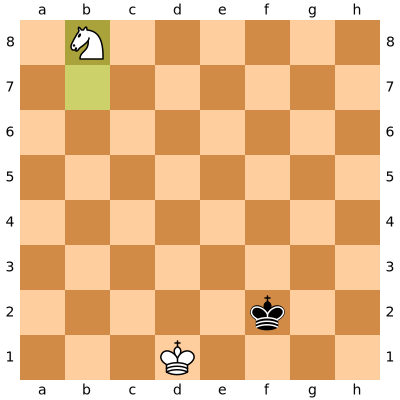

In [99]:
board

## Featurising the board position

In order to create features for the deep learning model, we will arrange the board position as a stack of `8 x 8` arrays. We will create one-hot encoded layers for each unique piece type and colour. The order of the first 12 layers will be as follows:

- White Pawn
- White Knight
- White Bishop
- White Rook
- White Queen
- White King

- Black Pawn
- Black Knight
- Black Bishop
- Black Rook
- Black Queen
- Black King

We can repeat this stack 4 times to store the past few moves on the board. This will be necessary to give the model the ability to detect 'En Passant'.

We will also add one more layer to indicate which rooks on the board are still capable of castling. And one last layer to indicate if it is the white player's turn.

That makes `12 x 4 + 2 = 50` layers over all, totalling `3200` input values.

## Building the Feature Matrix

Now I'll write the code to build the first `14` layers of the model from the game board.

In [158]:
input_data = np.zeros(shape = (14, 8, 8))
for i, colour in enumerate(chess.COLORS):
    for j, piece in enumerate(chess.PIECE_TYPES):
        k = i * len(chess.PIECE_TYPES) + j
        input_data[k, :, :] = int_to_mask(board.pieces_mask(color=colour, piece_type=piece))
        print(input_data[k, :, :])
        print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

Next we add the castling information:

In [161]:
input_data[k + 1, :, :] = int_to_mask(board.castling_rights)
input_data[k + 1, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

And lastly whose turn it is.

In [165]:
input_data[k + 2, :, :] = board.turn * np.ones((8, 8))
input_data[k + 2, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now we package these operations into a function that can generate the feature matrix for a given board.

In [171]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

Now that we have a sensible feature set, we have to create a model architecture, and then perform a forward pass with a random initialisation to make sure that the model output is well defined. Ideally, we would like to implement a Deep Residual Network. 

Once we have that, we will be able to start working on the Markov Chain Monte Carlo (MCMC) Tree Search implementation, and also the training loop for the model.

Some useful resources:
- https://codesachin.wordpress.com/2017/02/19/residual-neural-networks-as-ensembles/
- https://blog.waya.ai/deep-residual-learning-9610bb62c355

## Defining a Move

Before we can define the forward pass, we have define our target output. We want the model to map board positions to moves on the board, so we need a way to express what a particular move on the board looks like to the neural network.

All moves in chess are performed by selecting a piece, and moving it to a new square. At the same time that a piece is moved, there can be side-effects on the board (e.g. a piece capture, or another piece may move as in castling). This means that the target output can simply be a selection of a piece in one location, along with the target location where the piece has been moved.

In [173]:
import tensorflow as tf